<a href="https://colab.research.google.com/github/insu97/Deep-Learning-from-Scratch1/blob/main/04_%EC%8B%A0%EA%B2%BD%EB%A7%9D_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/Deep-Learning-from-Scratch/01/'

/content/drive/MyDrive/Deep-Learning-from-Scratch/01


In [3]:
import numpy as np
import sys, os
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

# 손실함수(loss function)
- 손실함수를 설정하는 이유 :
```
신경망을 학습할 때 정확도를 지표로 삼아서는 안 된다.
정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 되기 때문이다.
```

## 평균 제곱 오차(mean squared error, MSE)

In [4]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

## 교차 엔트로피 오차(cross entropy error, CEE)

In [5]:
def cross_entropy_error(y, t):
    delta = 1e-7 # log(0) 방지하기 위해서
    return -np.sum(t * np.log(y + delta))

### 미니배치 학습

In [6]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [7]:
print(x_train.shape, t_train.shape)

(60000, 784) (60000, 10)


In [8]:
# 1. 데이터가 하나인 경우와 데이터가 배치로 묶여 입력될 경우
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

In [9]:
# 2. 정답 레이블이 원-핫 인코딩이 아니라 '2', '7'처럼 숫자 레이블로 주어졌을 경우
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

# 수치 미분

In [10]:
# 나쁜 구현
## 1. 반올림오차 문제 -> 최종 계산 결과에 작은 값이 생략되어 오차가 발생
## 2. 차분 개선 -> 실제 미분값과 오차를 줄이기 위해서는 (x+h), (x-h) 일 때의 함수 f의 차분을 사용 -> 중심 차분, 중앙 차분이라고 함
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x-h)) / h

In [11]:
# 개선 코드
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

# 기울기
- 모든 변수의 편미분을 벡터로 정리한 것
- 기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향 : gradient 반대 방향

In [12]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h)계산
        x[idx] = tmp_val + h
        fxh1 = f(x)

        # f(x-h)계산
        x[idx] = tmp_val - h
        fxh2 = f(x)

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원

    return grad

## 경사 하강법
- 함수의 값을 점차 줄이는 것

In [13]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [14]:
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

### 구현

In [15]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3) # 정규분포로 초기화

    def predict(self, x):
        return np.dot(x, self.W)

    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z) # 활성화 함수
        loss = cross_entropy_error(y, t) # 손실 함수 계산

        return loss

In [16]:
net = simpleNet()
print(net.W)

[[-0.23833374  2.01841777 -0.28024906]
 [ 0.43851445 -0.79169708  0.05470381]]


In [17]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[ 0.25166276  0.49852329 -0.11891601]


In [18]:
np.argmax(p)

1

In [19]:
t = np.array([0, 0, 1]) # 정답 레이블

In [20]:
net.loss(x, t)

1.4592531659098456

In [21]:
# 방법 1
def f(W):
    return net.loss(x, t)

# 방법 2
f = lambda w: net.loss(x, t)

In [22]:
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.20199731  0.25855668 -0.46055399]
 [ 0.30299597  0.38783502 -0.69083099]]


# 2층 신경망 구현

In [23]:
from common.functions import *
from common.gradient import numerical_gradient

In [32]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y

    def loss(self, x, t):
        y = self.predict(x)
        return cross_entropy_error(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads

In [33]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [34]:
x = np.random.rand(100, 784) # 더미 입력 데이터
t = np.random.rand(100, 10)  # 더미 정답 레이블
y = net.predict(x)

In [35]:
grads = net.gradient(x, t) # net.numerical_gradient(x, t) : 느리다..

In [36]:
print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


# 미니배치 학습 구현

In [37]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [38]:
train_loss_list = []

In [39]:
# 하이퍼파라미터
iters_num= 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

In [43]:
import matplotlib.pyplot as plt

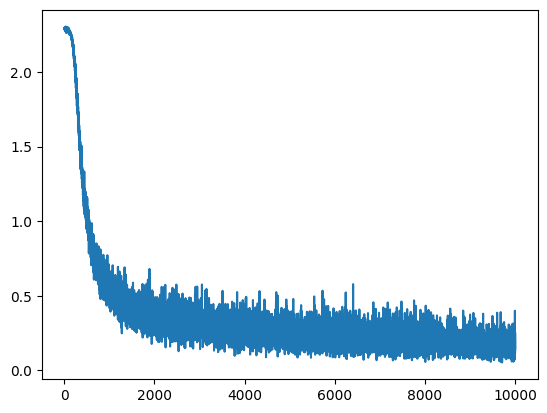

In [44]:
plt.plot(train_loss_list)
plt.show()

# 시험 데이터로 평가하기

In [45]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [46]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

In [47]:
# 하이퍼파라미터
iters_num= 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

In [48]:
train_loss_list = []
train_acc_list = []
test_acc_list = []

In [49]:
iter_per_epoch = max(train_size / batch_size, 1)

In [50]:
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.11236666666666667, 0.1135
train acc, test acc | 0.7946833333333333, 0.7999
train acc, test acc | 0.8764, 0.8799
train acc, test acc | 0.89845, 0.9029
train acc, test acc | 0.9070833333333334, 0.9103
train acc, test acc | 0.9144166666666667, 0.9175
train acc, test acc | 0.91895, 0.9221
train acc, test acc | 0.9233333333333333, 0.9226
train acc, test acc | 0.9272, 0.9292
train acc, test acc | 0.9309833333333334, 0.9305
train acc, test acc | 0.9338166666666666, 0.9339
train acc, test acc | 0.93695, 0.9378
train acc, test acc | 0.93835, 0.9373
train acc, test acc | 0.94085, 0.9392
train acc, test acc | 0.9436833333333333, 0.9425
train acc, test acc | 0.9452166666666667, 0.9436
train acc, test acc | 0.94715, 0.9463


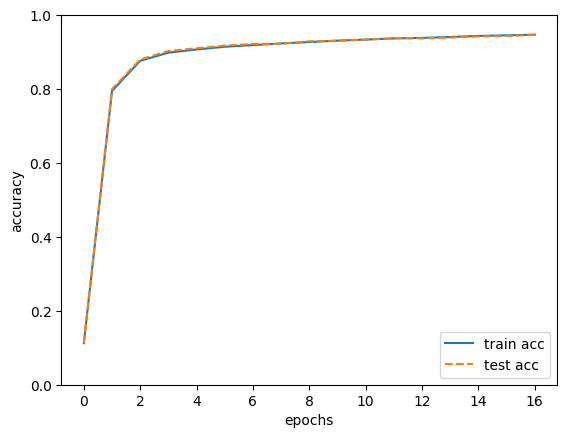

In [54]:
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()